In [1]:
import pycomod as pcm
import numpy as np

In [2]:
class simple2(pcm.Model):
    def build(self):
        
        P1 = self.pool(5)
        P2 = self.pool(5)
        
        a_v = self.parameter([0.001, 0.005, 0.02])
        a_t = self.parameter([0, 100, 200])
        
        a = self.step(a_v, a_t)
        
        b = self.impulse([2, 4, 6], [10, 20, 30])
        
        #F1 = self.flow(lambda: 0.02*P1, src=P1)
        #F2 = self.flow(lambda: 0.02*P2, src=P2, discrete=True)
        
        @self.flow(src=P1)
        def F1():
            return 0.02*P1
        
        @self.flow(src=P2, discrete=True)
        def F2():
            return 0.02*P2
        
        
        #N = self.equation(lambda: P1 + P2)
        
        @self.equation
        def N():
            return P1 + P2
        
        #F3 = self.flow(lambda: b, src=P1, dest=P2)
        
        self.set_available(locals(), output=(P1, P2, N))
        
m2 = simple2()

In [ ]:
m2.write_excel_init()

In [3]:
mgr = pcm.RunManager()
mgr.run(m2, duration=400, label='My run')
#mgr.run(m, init="init.xlsx", dt=1, tunit=np.timedelta64(1, 'D'), label='My run')


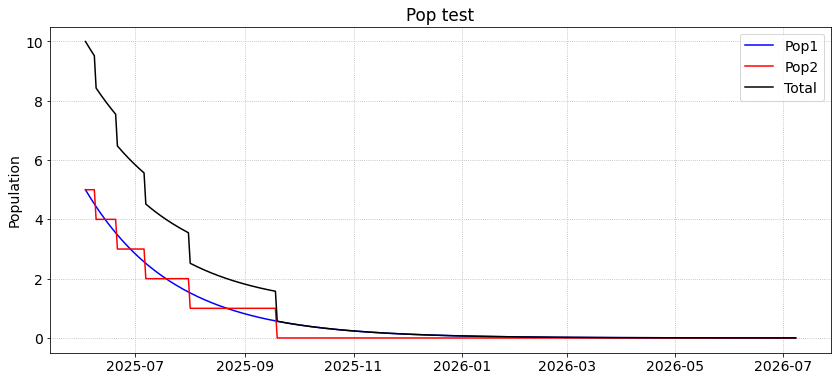

In [4]:
plt = pcm.Plotter(title='Pop test', ylabel='Population', fontsize=14)
plt.plot(mgr['My run'], 'P1', color='blue', label='Pop1')
plt.plot(mgr['My run'], 'P2', color='red', label='Pop2')
plt.plot(mgr['My run'], 'N', color='black', label='Total')

In [ ]:
class bigmodel(pcm.Model):
    def build(self):
        m1 = self.submodel(simple2())
        m2 = self.submodel(simple2())
        
        self.set_available(locals(), output=(m,))
        
m3 = bigmodel()

In [ ]:
m3.write_excel_init()

In [ ]:
mgr = pcm.RunManager()
#mgr.run(m3, duration=400, label='My run')
mgr.run(m3, init="init.xlsx", dt=1, tunit=np.timedelta64(1, 'D'), label='My run')


In [ ]:
plt = pcm.Plotter(title='Pop test', ylabel='Population', fontsize=14)
plt.plot(mgr['My run'], 'm.P1', color='blue', label='Pop1')
plt.plot(mgr['My run'], 'm.P2', color='black', label='Pop2')

In [ ]:
class Stuff:
    def __init__(self,):
        self.model = model
        
    def __call__(self, arg):
        def outer():
            print("outer start")
            arg()
            print("outer finish")

        return outer

stuff = Stuff
    
class Model:
    
#     def __init__(self):
#         def deco(arg):
#             def outer():
#                 print("outer start")
#                 arg()
#                 print("outer finish")
                
#             return outer
        
#         self.deco = deco
        
#         self.build()
        
#     def build(self):
#         pass
    
    def deco(self, arg):
        def wrapper():
            print("outer start")
            arg()
            print("outer finish")

        return wrapper
    
    def deco2(self, src, dest):
        def inner(arg):
            def wrapper():
                print("wrapper start")
                print(src, dest)
                arg()
                print("wrapper finish")
            return wrapper
        return inner
    
    def Event(self, *args, **kwargs):
        if len(args)==1 and len(kwargs)==0 and callable(args[0]):
            def wrapper():
                print("outer start")
                args[0]()
                print("outer finish")
            return wrapper
        else:
            def inner(arg):
                def wrapper():
                    print("wrapper start")
                    print(kwargs)
                    arg()
                    print("wrapper finish")
                return wrapper
            return inner
    
    
#     class Deco:
#         def __init__(self, model):
#             self.model = model
            
#         def __call__()


            
    

In [ ]:


class thing(Model):
    
    def build(self):
        
        @self.deco
        def foo():
            print("running foo")
            
        self.f = foo
        
        @self.deco2(src="pigs", dest="apples")
        def bar():
            print("running foo")
            
        self.b = bar
        
        @self.Event(start=True, repeat=True)
        #@self.Event
        def do_event():
            print("doing event")
            
        self.d = do_event
            
        

In [ ]:
x = thing()


In [ ]:
x.build()

In [ ]:
x.f()

In [ ]:
x.b()

In [ ]:
x.d()

In [ ]:
# TODO
# - get rid of step, allow parameters to optionally accept a list of values and times to change the parameter over time
# - get rid of impulse, this should be handled by an event with a schedule

